# Explainable AI for Image Classification


# Objective : 
- Interpretative Analysis with XAI: Using LIME and Grad-CAM techniques to visualize and understand the model’s regions of interest, facilitating better interpretation of the classification results.
Prerequisites

In [21]:

import lime
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

from skimage.segmentation import mark_boundaries

import tensorflow as tf
from skimage.morphology import disk
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, image

# --------------------------------------
# **Step 1: Load Model**
# --------------------------------------

In [4]:
model_path = 'model_xai_21.h5'

model = load_model(model_path)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# ---------------------------------------------------------------
# **Step 2: Explain the model using Grad Cam technique**
# --------------------------------------------------------------

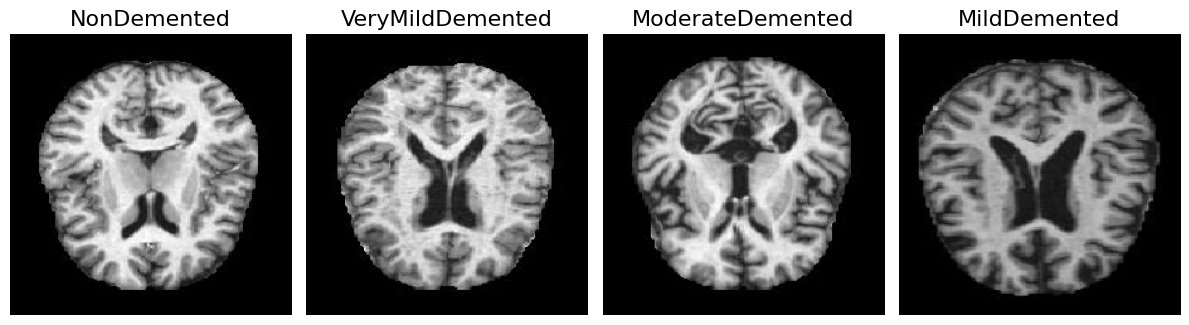

In [6]:
image_titles = ['NonDemented', 'VeryMildDemented','ModerateDemented','MildDemented']

img1 = load_img('OriginalDataset/NonDemented/nonDem1320.jpg', target_size=(224, 224))
img2 = load_img('OriginalDataset/VeryMildDemented/verymildDem1403.jpg', target_size=(224, 224))
img3 = load_img('OriginalDataset/ModerateDemented/moderateDem13.jpg', target_size=(224, 224))
img4 = load_img('DataSet/AugmentedAlzheimerDataset/MildDemented/1b4e9385-43ff-4858-bf1a-d9d056a2ba83.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3),np.array(img4)])

X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [24]:
def get_grad_cam(model, img_path, label_idx=None, layer_name=None):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)


    if label_idx is None:
        preds = model.predict(img_array)
        label_idx = np.argmax(preds)


    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(layer_name).output, model.output])


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, label_idx]

    output = conv_outputs[0]

    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = tf.reduce_sum(output * weights, axis=2)

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

def overlay_grad_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    return overlaid_img

def explain_with_grad_cam(model, class_names, img_path, label_idx=None, layer_name=None):
    heatmap = get_grad_cam(model, img_path, label_idx, layer_name)
    overlaid_img = overlay_grad_cam(img_path, heatmap)

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds)
    predicted_class = class_names[predicted_class_idx]


    true_label = img_path.split('/')[-2]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Original Image\nTrue Label: {true_label}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlaid_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPrediction: {predicted_class}")
    plt.axis("off")

    plt.show()
       
 
  
        
class_names=['MildDemented','ModerateDemented','NonDemented', 'VeryMildDemented']



1/1 [==============================] - 0s 32ms/step


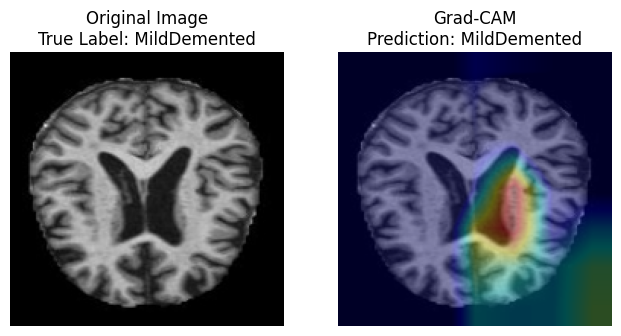

In [25]:
image_path = 'DataSet//AugmentedAlzheimerDataset/MildDemented/1b4e9385-43ff-4858-bf1a-d9d056a2ba83.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 31ms/step


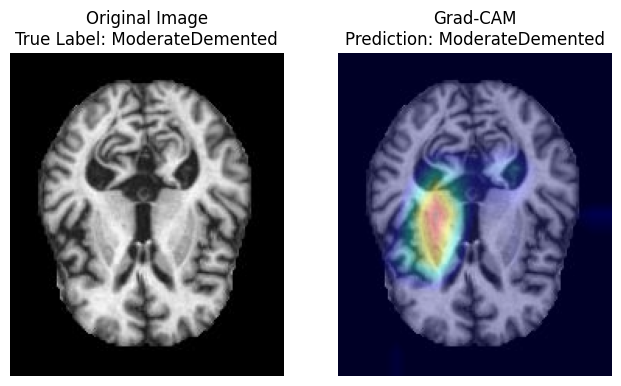

In [26]:
image_path ='OriginalDataset/ModerateDemented/moderateDem13.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 16ms/step


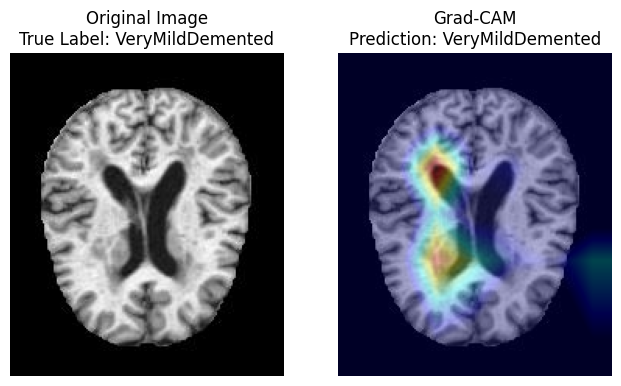

In [27]:
image_path ='OriginalDataset/VeryMildDemented/verymildDem1479.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 30ms/step


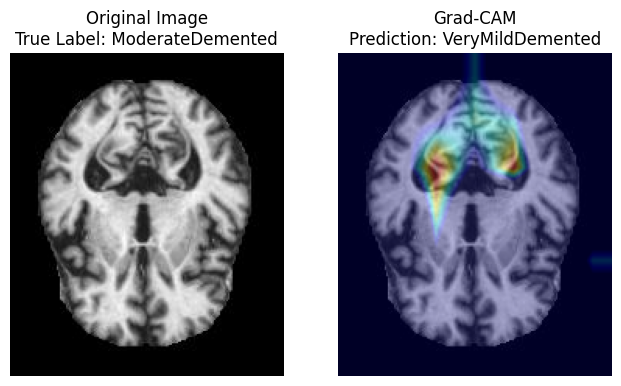

In [28]:
image_path ='OriginalDataset/ModerateDemented/moderateDem7.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 21ms/step


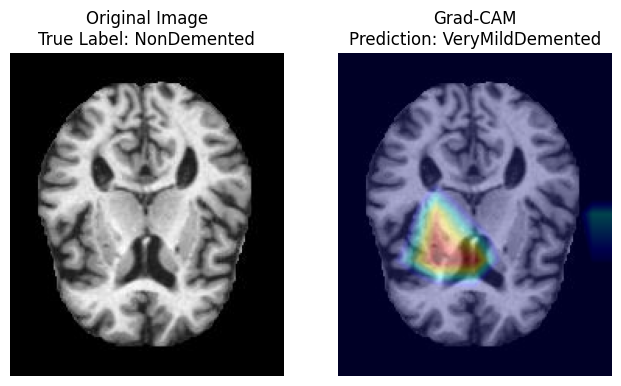

In [29]:
image_path ='OriginalDataset/NonDemented/nonDem1131.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

# ---------------------------------------------------------------
# **Step 2: Explain the model using Lime technique**
# --------------------------------------------------------------

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 10/1000 [00:00<00:38, 25.95it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 20/1000 [00:00<00:25, 38.95it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 30/1000 [00:00<00:20, 47.25it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 40/1000 [00:00<00:18, 52.26it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 50/1000 [00:01<00:16, 56.40it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 60/1000 [00:01<00:15, 59.08it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 70/1000 [00:01<00:15, 60.79it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 80/1000 [00:01<00:15, 59.84it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 90/1000 [00:01<00:14, 61.59it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 100/1000 [00:01<00:14, 61.72it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 110/1000 [00:01<00:14, 62.01it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 120/1000 [00:02<00:13, 63.05it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 130/1000 [00:02<00:13, 62.39it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 140/1000 [00:02<00:13, 64.01it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 150/1000 [00:02<00:13, 65.06it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 65.28it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 66.15it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 180/1000 [00:03<00:12, 66.21it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 190/1000 [00:03<00:12, 66.92it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 200/1000 [00:03<00:12, 66.26it/s]

1/1 [==============================] - 0s 74ms/step


 21%|██        | 210/1000 [00:03<00:13, 57.14it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 220/1000 [00:03<00:13, 56.50it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 230/1000 [00:03<00:13, 58.57it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 240/1000 [00:04<00:12, 59.56it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 250/1000 [00:04<00:12, 61.85it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 260/1000 [00:04<00:11, 62.67it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 270/1000 [00:04<00:11, 63.06it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 280/1000 [00:04<00:11, 64.54it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 65.63it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 300/1000 [00:04<00:10, 65.80it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 310/1000 [00:05<00:10, 67.03it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 320/1000 [00:05<00:10, 67.48it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 330/1000 [00:05<00:10, 66.80it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 65.14it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 66.54it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 65.00it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 370/1000 [00:06<00:09, 64.56it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 380/1000 [00:06<00:09, 63.92it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 390/1000 [00:06<00:09, 62.74it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 400/1000 [00:06<00:09, 63.89it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 410/1000 [00:06<00:09, 64.34it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 420/1000 [00:06<00:09, 64.31it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 65.54it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 440/1000 [00:07<00:08, 65.50it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 450/1000 [00:07<00:08, 64.57it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 64.49it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 470/1000 [00:07<00:08, 64.27it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 480/1000 [00:07<00:08, 63.42it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 64.84it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 500/1000 [00:08<00:07, 65.19it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 510/1000 [00:08<00:07, 65.35it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 520/1000 [00:08<00:07, 65.56it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 65.66it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 540/1000 [00:08<00:06, 66.73it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 550/1000 [00:08<00:06, 67.03it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 67.10it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 570/1000 [00:09<00:06, 67.80it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 580/1000 [00:09<00:06, 66.16it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 65.05it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 600/1000 [00:09<00:06, 65.14it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 610/1000 [00:09<00:05, 65.57it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 66.76it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 630/1000 [00:10<00:05, 67.61it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 640/1000 [00:10<00:05, 68.46it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 650/1000 [00:10<00:05, 68.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 660/1000 [00:10<00:04, 68.73it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 670/1000 [00:10<00:04, 66.91it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 680/1000 [00:10<00:04, 67.26it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 68.06it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 700/1000 [00:11<00:04, 68.64it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 710/1000 [00:11<00:04, 68.43it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 69.07it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 730/1000 [00:11<00:03, 68.80it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 740/1000 [00:11<00:03, 68.56it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 68.48it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 68.88it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 770/1000 [00:12<00:03, 70.09it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 780/1000 [00:12<00:03, 69.24it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 790/1000 [00:12<00:03, 69.17it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 800/1000 [00:12<00:02, 68.19it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 810/1000 [00:12<00:02, 67.20it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 820/1000 [00:12<00:02, 67.00it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 67.80it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 840/1000 [00:13<00:02, 67.62it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 67.77it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 860/1000 [00:13<00:02, 67.97it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 870/1000 [00:13<00:01, 69.76it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 880/1000 [00:13<00:01, 67.92it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 890/1000 [00:13<00:01, 67.87it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 69.87it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 910/1000 [00:14<00:01, 67.56it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 920/1000 [00:14<00:01, 67.02it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 930/1000 [00:14<00:01, 67.24it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 940/1000 [00:14<00:00, 67.78it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 950/1000 [00:14<00:00, 69.08it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 960/1000 [00:14<00:00, 66.44it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 66.40it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 980/1000 [00:15<00:00, 69.00it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 990/1000 [00:15<00:00, 66.41it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 1000/1000 [00:15<00:00, 64.77it/s]


1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0884745].


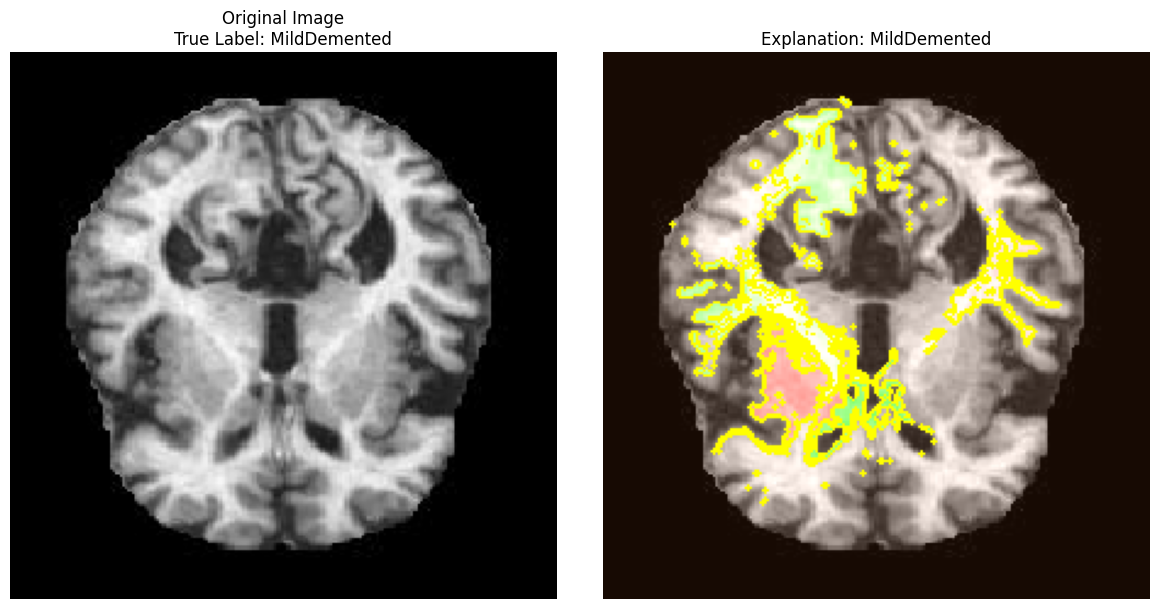

Model Predictions:
MildDemented: 0.8578
ModerateDemented: 0.0003
NonDemented: 0.0576
VeryMildDemented: 0.0843




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 10/1000 [00:00<00:15, 65.38it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 20/1000 [00:00<00:14, 66.24it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 30/1000 [00:00<00:14, 67.48it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 40/1000 [00:00<00:14, 68.46it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 50/1000 [00:00<00:13, 68.98it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 60/1000 [00:00<00:13, 70.02it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 70/1000 [00:01<00:13, 69.54it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 80/1000 [00:01<00:13, 69.86it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 90/1000 [00:01<00:12, 70.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 100/1000 [00:01<00:12, 70.18it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 110/1000 [00:01<00:12, 70.60it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 71.08it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 71.32it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 73.13it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 70.65it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 69.68it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 70.70it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 70.92it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 72.49it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 200/1000 [00:02<00:11, 72.34it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 210/1000 [00:02<00:11, 69.75it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 220/1000 [00:03<00:11, 67.03it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 230/1000 [00:03<00:11, 67.67it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 70.12it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 70.90it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 70.44it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 68.80it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 68.52it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 69.55it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 300/1000 [00:04<00:09, 71.44it/s]

1/1 [==============================] - 0s 9ms/step


 31%|███       | 310/1000 [00:04<00:09, 71.99it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 69.92it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 71.30it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 71.50it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 350/1000 [00:04<00:09, 71.65it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 70.55it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 70.06it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 380/1000 [00:05<00:08, 69.90it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 70.40it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 400/1000 [00:05<00:08, 72.05it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 410/1000 [00:05<00:08, 72.58it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 420/1000 [00:05<00:08, 72.49it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 430/1000 [00:06<00:07, 72.60it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 440/1000 [00:06<00:07, 72.70it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 71.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 69.98it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 71.10it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 72.28it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 490/1000 [00:06<00:07, 72.08it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 500/1000 [00:07<00:06, 72.10it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 510/1000 [00:07<00:06, 70.81it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 71.77it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 71.85it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 70.80it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 69.95it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 560/1000 [00:07<00:06, 70.95it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 70.57it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 580/1000 [00:08<00:05, 70.55it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 590/1000 [00:08<00:05, 70.47it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 600/1000 [00:08<00:05, 70.70it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 610/1000 [00:08<00:05, 71.10it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 72.23it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 630/1000 [00:08<00:05, 70.47it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 70.14it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 650/1000 [00:09<00:04, 72.02it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 69.95it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 70.25it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 70.57it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 70.63it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 700/1000 [00:09<00:04, 72.49it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 710/1000 [00:10<00:04, 72.35it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 720/1000 [00:10<00:03, 70.59it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 70.14it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 70.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 71.22it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 71.26it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 770/1000 [00:10<00:03, 70.16it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 70.09it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 790/1000 [00:11<00:02, 71.71it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 800/1000 [00:11<00:02, 70.97it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 810/1000 [00:11<00:02, 70.62it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 69.52it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 66.92it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 840/1000 [00:11<00:02, 67.78it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 67.54it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 68.32it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 69.37it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 68.14it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 69.22it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 900/1000 [00:12<00:01, 67.68it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 68.80it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 67.80it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 930/1000 [00:13<00:01, 66.51it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 67.13it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 66.61it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 67.08it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 66.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 66.54it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 67.74it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 1000/1000 [00:14<00:00, 70.05it/s]


1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.092396].


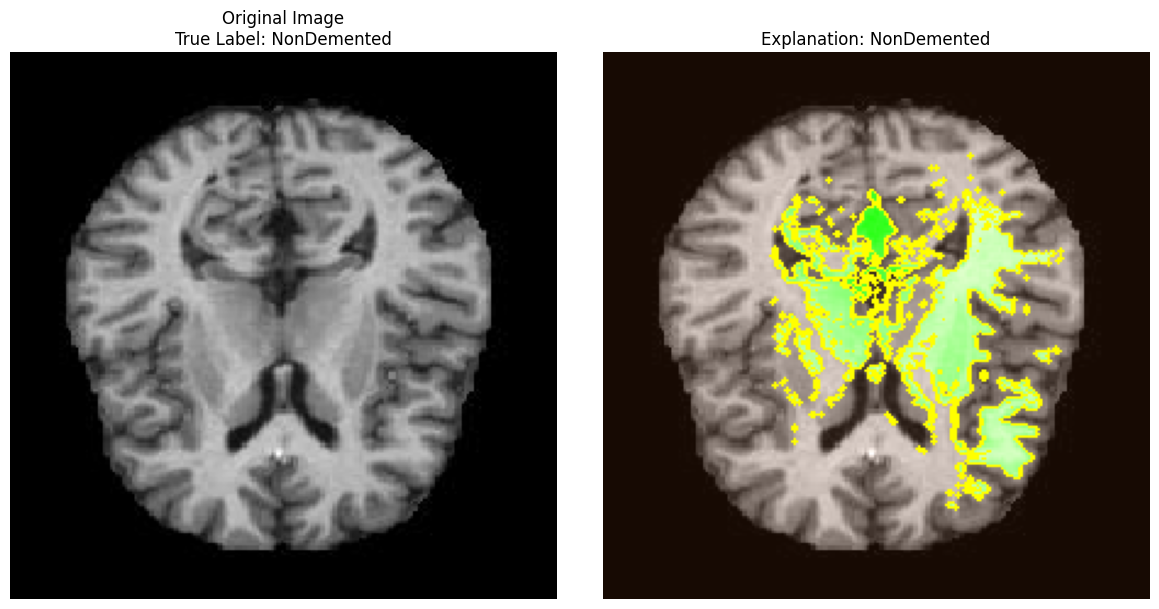

Model Predictions:
MildDemented: 0.0000
ModerateDemented: 0.0000
NonDemented: 1.0000
VeryMildDemented: 0.0000




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 10/1000 [00:00<00:15, 65.40it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 20/1000 [00:00<00:15, 62.87it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 30/1000 [00:00<00:15, 61.43it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 40/1000 [00:00<00:16, 59.90it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 50/1000 [00:00<00:16, 57.36it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 60/1000 [00:01<00:15, 59.35it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 70/1000 [00:01<00:15, 60.89it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 80/1000 [00:01<00:14, 63.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 90/1000 [00:01<00:13, 65.01it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 100/1000 [00:01<00:13, 66.71it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 110/1000 [00:01<00:13, 67.87it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 68.56it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 130/1000 [00:02<00:12, 67.80it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 140/1000 [00:02<00:12, 69.19it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 69.95it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 70.57it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 69.65it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 68.80it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 69.73it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 200/1000 [00:03<00:11, 69.34it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 210/1000 [00:03<00:11, 69.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 220/1000 [00:03<00:11, 70.87it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 70.84it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 70.15it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 69.69it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 70.35it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 270/1000 [00:04<00:10, 70.37it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 70.82it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 290/1000 [00:04<00:09, 73.36it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 300/1000 [00:04<00:09, 70.31it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 310/1000 [00:04<00:09, 69.27it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 69.28it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 70.09it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 340/1000 [00:05<00:09, 70.45it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 68.35it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 69.23it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 370/1000 [00:05<00:09, 69.20it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 380/1000 [00:05<00:09, 68.27it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 69.96it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 400/1000 [00:05<00:08, 69.49it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 410/1000 [00:06<00:08, 68.42it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 68.33it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 68.29it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 69.74it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▌     | 450/1000 [00:06<00:08, 68.57it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 67.87it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 67.88it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 480/1000 [00:07<00:07, 68.18it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 68.17it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 500/1000 [00:07<00:07, 69.45it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 510/1000 [00:07<00:07, 66.14it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 520/1000 [00:07<00:07, 66.35it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 530/1000 [00:07<00:07, 64.41it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 540/1000 [00:07<00:07, 62.53it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 550/1000 [00:08<00:07, 64.11it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 65.07it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 66.29it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 65.86it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 590/1000 [00:08<00:06, 65.80it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 600/1000 [00:08<00:05, 67.72it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 610/1000 [00:09<00:05, 68.40it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 70.58it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 71.11it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 70.33it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 650/1000 [00:09<00:04, 70.47it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 71.11it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 72.27it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 70.03it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 70.17it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 700/1000 [00:10<00:04, 72.08it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 710/1000 [00:10<00:04, 70.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 720/1000 [00:10<00:03, 70.45it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 72.19it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 70.86it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 72.06it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 70.49it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 70.89it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 72.47it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 790/1000 [00:11<00:02, 70.69it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 800/1000 [00:11<00:02, 70.02it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 810/1000 [00:11<00:02, 71.66it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 70.46it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 71.00it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 71.53it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 71.54it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 860/1000 [00:12<00:01, 71.31it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 72.30it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 70.19it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 70.58it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 69.89it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 70.69it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 70.78it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 930/1000 [00:13<00:00, 70.40it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 70.28it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 70.36it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 70.59it/s]

1/1 [==============================] - 0s 11ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 71.33it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 71.30it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 70.26it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 1000/1000 [00:14<00:00, 68.96it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0610235].


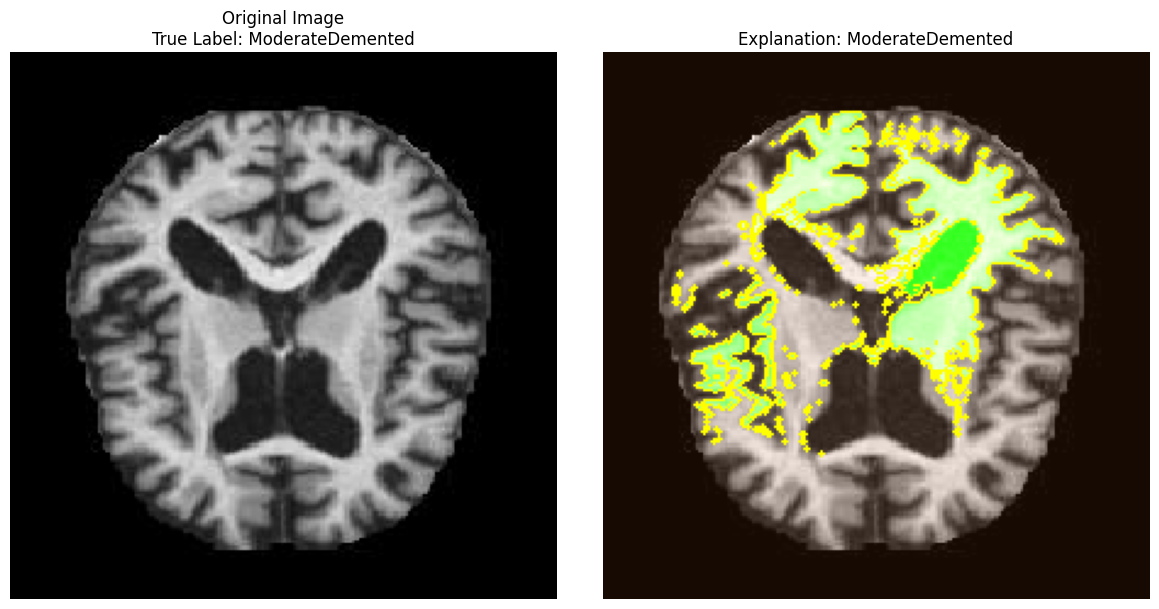

Model Predictions:
MildDemented: 0.0000
ModerateDemented: 1.0000
NonDemented: 0.0000
VeryMildDemented: 0.0000




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 10/1000 [00:00<00:14, 68.65it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 20/1000 [00:00<00:14, 68.34it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 30/1000 [00:00<00:14, 67.26it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 40/1000 [00:00<00:14, 67.49it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 50/1000 [00:00<00:13, 69.36it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 60/1000 [00:00<00:13, 67.52it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 70/1000 [00:01<00:13, 67.77it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 80/1000 [00:01<00:13, 67.98it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 90/1000 [00:01<00:13, 67.83it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 100/1000 [00:01<00:13, 68.89it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 110/1000 [00:01<00:12, 69.83it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 69.70it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 69.46it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 140/1000 [00:02<00:12, 69.61it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 68.98it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 69.21it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 69.90it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 69.25it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 68.92it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 200/1000 [00:02<00:11, 69.22it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 210/1000 [00:03<00:11, 68.13it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 220/1000 [00:03<00:11, 67.66it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 230/1000 [00:03<00:11, 68.44it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 69.18it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 69.87it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 69.73it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 69.90it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 69.82it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 68.91it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 300/1000 [00:04<00:10, 69.42it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 310/1000 [00:04<00:09, 71.50it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 69.40it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 69.43it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 69.49it/s]

1/1 [==============================] - 0s 9ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 69.74it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 69.94it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 70.12it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 380/1000 [00:05<00:08, 69.49it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 68.91it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 400/1000 [00:05<00:08, 69.07it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 410/1000 [00:05<00:08, 69.17it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 69.42it/s]

1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 69.02it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 440/1000 [00:06<00:09, 61.69it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 450/1000 [00:06<00:08, 63.53it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 460/1000 [00:06<00:08, 64.97it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 66.55it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 480/1000 [00:07<00:07, 66.52it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 67.71it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 500/1000 [00:07<00:07, 67.60it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 510/1000 [00:07<00:07, 68.27it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 520/1000 [00:07<00:07, 67.68it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 68.15it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 69.02it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 550/1000 [00:08<00:06, 69.18it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 69.41it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 68.37it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 69.52it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 590/1000 [00:08<00:05, 68.79it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 600/1000 [00:08<00:05, 69.26it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 610/1000 [00:08<00:05, 69.62it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 69.50it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 69.65it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 69.92it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 650/1000 [00:09<00:04, 70.02it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 70.28it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 68.94it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 69.33it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 69.65it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 700/1000 [00:10<00:04, 69.82it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 710/1000 [00:10<00:04, 69.76it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 720/1000 [00:10<00:04, 69.16it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 68.36it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 68.50it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 68.38it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 68.08it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 66.62it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 66.93it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 66.91it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 800/1000 [00:11<00:02, 66.78it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 810/1000 [00:11<00:02, 67.28it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 67.36it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 67.41it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 67.69it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 68.00it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 68.24it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 68.39it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 67.03it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 68.79it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 67.35it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 67.96it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 68.54it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 930/1000 [00:13<00:01, 69.66it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 70.35it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 69.69it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 69.05it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 69.45it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 68.43it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 68.86it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 1000/1000 [00:14<00:00, 68.60it/s]


1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0806314].


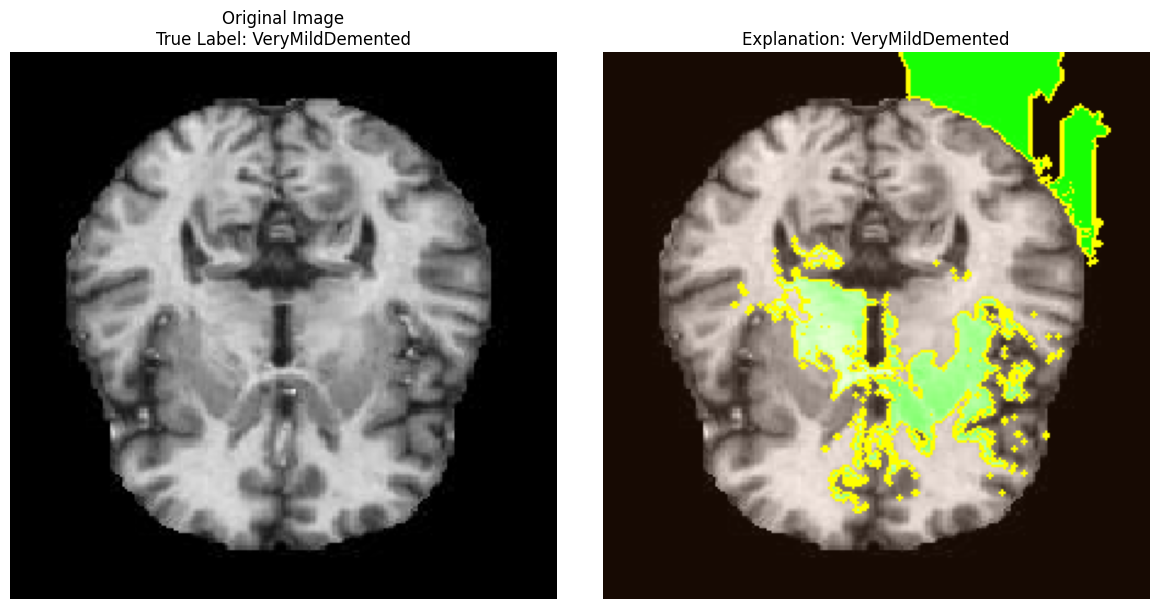

Model Predictions:
MildDemented: 0.0000
ModerateDemented: 0.0000
NonDemented: 0.0000
VeryMildDemented: 1.0000




In [33]:
def explain_and_visualize(model, image_paths, class_names, num_samples=1000, num_features=5):

    explainer = lime_image.LimeImageExplainer()

    for image_path in image_paths:

        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)


        def predict_fn(images):
            return model.predict(images)

        explanation = explainer.explain_instance(
            img_array[0],
            predict_fn,
            top_labels=1,
            num_samples=num_samples
        )
        true_label = image_path.split('/')[-2]

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=num_features,
            hide_rest=False
        )

        preds = model.predict(img_array)
        predicted_class_idx = np.argmax(preds)
        predicted_class = class_names[predicted_class_idx]
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original Image\nTrue Label: {true_label}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mark_boundaries(temp / 255 + 0.5, mask))
        plt.title(f"Explanation: {predicted_class}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print("Model Predictions:")
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {preds[0][i]:.4f}")
        print("\n")


class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
image_paths = ['OriginalDataset/MildDemented/mildDem139.jpg', 'OriginalDataset/NonDemented/nonDem1020.jpg', 'OriginalDataset/ModerateDemented/moderateDem32.jpg', 'OriginalDataset/VeryMildDemented/verymildDem142.jpg']

explain_and_visualize(model, image_paths, class_names)
